# Imports

In [1]:
import cv2
import sys
import os
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
from Misc.MiscUtils import *
from Misc.DataUtils import *
import numpy as np
import time
import argparse
import shutil
from io import StringIO
import string
from termcolor import colored, cprint
import math as m
from tqdm import tqdm
import csv
from sklearn.preprocessing import StandardScaler
# Don't generate pyc codes
sys.dont_write_bytecode = True

import tensorflow as tf

from keras import backend as K

from keras.utils import Sequence
from keras.initializers import VarianceScaling
from keras.models import Sequential
from keras.layers import  Activation, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, InputLayer
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
from Misc.TFSpatialTransformer import transformer


print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Num GPUs Available:  1


# Define Functions

In [2]:

######################### Data functions
def alternateH4Axis(Y_train):
    H4 = np.zeros_like(Y_train) 
    batch_size= Y_train.shape[0] # column count

    H4[:batch_size, 0] = Y_train[:batch_size,0]
    H4[:batch_size, 1] = Y_train[:batch_size,4]
    H4[:batch_size, 2] = Y_train[:batch_size,1]
    H4[:batch_size, 3] = Y_train[:batch_size,5]
    H4[:batch_size, 4] = Y_train[:batch_size,2]
    H4[:batch_size, 5] = Y_train[:batch_size,6]
    H4[:batch_size, 6] = Y_train[:batch_size,3]
    H4[:batch_size, 7] = Y_train[:batch_size,7]
    return H4

######################### Visualization functions
def getCornersFromH4pt(corner1, H4pt):
    corners1 = np.array(corner1.copy())
    del_corners = H4pt.reshape(2,4).T
    corners2 = corners1 + del_corners
    return corners2

def drawCorners(image, corners, color):

    corners_ = np.array(corners.copy())
    r = corners_[2,:].copy()
    corners_[2,:] = corners_[3,:]
    corners_[3,:] = r
    corners_ = corners_.reshape(-1,1,2)
#     print(corners_)
    corners_ = corners_.astype(int)
    image_corners = cv2.polylines(image.copy(),[corners_],True,color, 4)
    return image_corners

def getHfromH4pt(corners1, H4pt):
#     print("H4pt is: ")
#     print(H4pt.reshape(2,4).T)

    del_corners = H4pt.reshape(2,4).T
    
    corners1 = np.array(corners1)
#     print("corner1 is: ")
#     print(corners1)

    corners2 = corners1 + del_corners
#     print("corner2 is: ")
#     print(corners2)

    H = cv2.getPerspectiveTransform(np.float32(corners1), np.float32(corners2))
#     print("H is:")
#     print(H)
    return H

def warpImage(img, corners, H):
    image = img.copy()
    h, w, _= image.shape

    corners_ = np.array(corners)
    corners_ = corners_.reshape((-1,1,2))

    image_transformed = cv2.warpPerspective(image, H, (w,h))
    corner_transformed = cv2.perspectiveTransform(np.float32(corners_), H)
    corner_transformed = corner_transformed.astype(int)
    
    return image_transformed, corner_transformed

######################### DL functions
def HomographyNet():

#     hidden_layer_size, num_classes = 1000, 8
    input_shape = (128, 128, 2)
    kernel_size = 3
    pool_size = 2
    filters = 64
    dropout = 0.5

    kernel_initializer = VarianceScaling(scale=2.0)
    
    model = Sequential()
    model.add(InputLayer(input_shape))
    ## conv2d 128
    model.add(Conv2D(filters=filters,kernel_size = kernel_size, activation ='relu', padding ='same'))
    model.add(BatchNormalization())
    
    ## conv2d 128
    model.add(Conv2D(filters = filters,kernel_size = kernel_size, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size))
    
    ## conv2d 64
    model.add(Conv2D(filters=filters,kernel_size=kernel_size, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    ## conv2d 64
    model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size))
    
    ## conv2d 32 2x Filters
    model.add(Conv2D(filters=filters*2,kernel_size=kernel_size, activation='relu', padding='same',))
    model.add(BatchNormalization())
    ## conv2d 32 2x Filters
    model.add(Conv2D(filters=filters*2,kernel_size=kernel_size, activation='relu', padding='same',))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size))
    
    ## conv2d 16 2x Filters
    model.add(Conv2D(filters=filters*2, kernel_size=kernel_size, activation='relu', padding='same',))
    model.add(BatchNormalization())
    ## conv2d 16 2x Filters
    model.add(Conv2D(filters=filters*2, kernel_size=kernel_size, activation='relu', padding='same',))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout))
    #for regression model
    model.add(Dense(8))
    return model

#Loss Function using SMSE
def L2_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1, keepdims=True))

############################################## Unsupervised functions........

def TensorDLT(H4, corners_a , batch_size):
    
    corners_a_tile = tf.expand_dims(corners_a, [2]) # BATCH_SIZE x 8 x 1
    
    # Solve for H using DLT
    pred_h4p_tile = tf.expand_dims(H4, [2]) # BATCH_SIZE x 8 x 1
    # 4 points on the second image
    pred_corners_b_tile = tf.add(pred_h4p_tile, corners_a_tile)


    # Auxiliary tensors used to create Ax = b equation
    M1_tile = tf.tile(tf.expand_dims(tf.constant(Aux_M1,tf.float32),[0]),[batch_size,1,1])
    M2_tile = tf.tile(tf.expand_dims(tf.constant(Aux_M2,tf.float32),[0]),[batch_size,1,1])
    M3_tile = tf.tile(tf.expand_dims(tf.constant(Aux_M3,tf.float32),[0]),[batch_size,1,1])
    M4_tile = tf.tile(tf.expand_dims(tf.constant(Aux_M4,tf.float32),[0]),[batch_size,1,1])
    M5_tile = tf.tile(tf.expand_dims(tf.constant(Aux_M5,tf.float32),[0]),[batch_size,1,1])
    M6_tile = tf.tile(tf.expand_dims(tf.constant(Aux_M6,tf.float32),[0]),[batch_size,1,1])
    M71_tile = tf.tile(tf.expand_dims(tf.constant(Aux_M71,tf.float32),[0]),[batch_size,1,1])
    M72_tile = tf.tile(tf.expand_dims(tf.constant(Aux_M72,tf.float32),[0]),[batch_size,1,1])
    M8_tile = tf.tile(tf.expand_dims(tf.constant(Aux_M8,tf.float32),[0]),[batch_size,1,1])
    Mb_tile = tf.tile(tf.expand_dims(tf.constant(Aux_Mb,tf.float32),[0]),[batch_size,1,1])

    # Form the equations Ax = b to compute H
    # Form A matrix
    A1 = tf.matmul(M1_tile, corners_a_tile) # Column 1
    A2 = tf.matmul(M2_tile, corners_a_tile) # Column 2
    A3 = M3_tile                   # Column 3
    A4 = tf.matmul(M4_tile, corners_a_tile) # Column 4
    A5 = tf.matmul(M5_tile, corners_a_tile) # Column 5
    A6 = M6_tile                   # Column 6
    A7 = tf.matmul(M71_tile, pred_corners_b_tile) *  tf.matmul(M72_tile, corners_a_tile)# Column 7
    A8 = tf.matmul(M71_tile, pred_corners_b_tile) *  tf.matmul(M8_tile, corners_a_tile)# Column 8

    A_mat = tf.transpose(tf.stack([tf.reshape(A1,[-1,8]),tf.reshape(A2,[-1,8]),\
                                   tf.reshape(A3,[-1,8]),tf.reshape(A4,[-1,8]),\
                                   tf.reshape(A5,[-1,8]),tf.reshape(A6,[-1,8]),\
                                   tf.reshape(A7,[-1,8]),tf.reshape(A8,[-1,8])],axis=1), perm=[0,2,1]) # BATCH_SIZE x 8 (A_i) x 8


    print('--Shape of A_mat:', A_mat.get_shape().as_list())
    # Form b matrix
    b_mat = tf.matmul(Mb_tile, pred_corners_b_tile)
    print('--shape of b:', b_mat.get_shape().as_list())

    # Solve the Ax = b
    H_8el = tf.matrix_solve(A_mat , b_mat)  # BATCH_SIZE x 8.
    print('--shape of H_8el', H_8el)


    # Add ones to the last cols to reconstruct H for computing reprojection error
    h_ones = tf.ones([batch_size, 1, 1])
    H_9el = tf.concat([H_8el,h_ones],1)
    H_flat = tf.reshape(H_9el, [-1,9])
    H_mat = tf.reshape(H_flat,[-1,3,3])   # BATCH_SIZE x 3 x 3

    return H_mat

def homographyNet(Img):
   
    # Convolutional Layers     
    x = tf.layers.conv2d(inputs=Img, name='Conv2D1', padding='same',filters=64, kernel_size=[3,3], activation=None)
    x = tf.layers.batch_normalization(x, name='BatchNorm1')
    x = tf.nn.relu(x, name='Relu1')

    x = tf.layers.conv2d(inputs=x, name='Conv2D2', padding='same',filters=64, kernel_size=[3,3], activation=None) 
    x = tf.layers.batch_normalization(x, name='BatchNorm2')
    x = tf.nn.relu(x, name='Relu2')

    x = tf.layers.max_pooling2d(inputs=x, pool_size=[2,2], strides=2)

    x = tf.layers.conv2d(inputs=x, name='Conv2D3', padding='same',filters=64, kernel_size=[3,3], activation=None)
    x = tf.layers.batch_normalization(x, name='BatchNorm3')
    x = tf.nn.relu(x, name='Relu3')

    x = tf.layers.conv2d(inputs=x, name='Conv2D4', padding='same',filters=64, kernel_size=[3,3], activation=None)
    x = tf.layers.batch_normalization(x, name='BatchNorm4')
    x = tf.nn.relu(x, name='Relu4')

    x = tf.layers.max_pooling2d(inputs=x, pool_size=[2,2], strides=2)

    x = tf.layers.conv2d(inputs=x, name='Conv2D5', padding='same',filters=128, kernel_size=[3,3], activation=None)
    x = tf.layers.batch_normalization(x, name='BatchNorm5')
    x = tf.nn.relu(x, name='Relu5')

    x = tf.layers.conv2d(inputs=x, name='Conv2D6', padding='same',filters=128, kernel_size=[3,3], activation=None)
    x = tf.layers.batch_normalization(x, name='BatchNorm6')
    x = tf.nn.relu(x, name='Relu6')

    x = tf.layers.max_pooling2d(inputs=x, pool_size=[2,2], strides=2)
    
    x = tf.layers.conv2d(inputs=x, name='Conv2D7', padding='same',filters=128, kernel_size=[3,3], activation=None)
    x = tf.layers.batch_normalization(x, name='BatchNorm7')
    x = tf.nn.relu(x, name='Relu7')

    x = tf.layers.conv2d(inputs=x, name='Conv2D8', padding='same',filters=128, kernel_size=[3,3], activation=None)
    x = tf.layers.batch_normalization(x, name='BatchNorm8')
    x = tf.nn.relu(x, name='Relu8')

    #flattening layer
    x = tf.contrib.layers.flatten(x)

    #Fully-connected layers
    x = tf.layers.dense(inputs=x, name='FC1',units=1024, activation=tf.nn.relu)
    x = tf.layers.dropout(x,rate=0.5, training=True,name='Dropout')
    x = tf.layers.batch_normalization(x, name='BatchNorm9')
    H4 = tf.layers.dense(inputs=x, name='FCfinal',units=8, activation=None)

    return H4

def getPatchIndices(corners_a):
    patch_indices = []
    for i in range(corners_a.shape[0]):
        xmin,ymin = corners_a[i,0,0], corners_a[i,0,1]
        xmax,ymax = corners_a[i,3,0], corners_a[i,3,1]
#         print(xmin,ymin,xmax,ymax)
        X, Y = np.mgrid[xmin:xmax, ymin:ymax]
        patch_indices.append(np.dstack((Y,X))) 
    return np.array(patch_indices)

# Train the model, save and test

# Read Files and Load training Data 
-- all data in memory, not in batches

In [3]:
path = '/home/gokul/CMSC733/hgokul_p1/Phase2/Data/Train_synthetic/'
pointsList = np.load(path+'pointsList.npy')
all_labels = pd.read_csv(path+'H4.csv', index_col = False)
all_labels = all_labels.to_numpy()
print(pointsList.shape, all_labels.shape)
all_patchNames = pd.read_csv(path + "ImageFileNames.csv")
all_patchNames = all_patchNames.to_numpy()

n  = 10
X_train, Ia_batches, Ib_batches = [],[],[]
for i, p in enumerate(all_patchNames[:n]):

    tPatchA = cv2.imread(path+"PA/"+ str(p[0]), cv2.IMREAD_GRAYSCALE)
    tPatchB = cv2.imread(path+"PB/"+ str(p[0]), cv2.IMREAD_GRAYSCALE)
    tPatch = np.dstack((tPatchA, tPatchB))    
    
    Ia_batches.append(cv2.imread(path+"IA/"+ str(p[0]), cv2.IMREAD_GRAYSCALE))
    Ib_batches.append(cv2.imread(path+"IB/"+ str(p[0]), cv2.IMREAD_GRAYSCALE))
    
    X_train.append(tPatch)

Ib_batches = np.array(Ib_batches)
Ia_batches = np.array(Ia_batches)    
X_train = np.array(X_train)    
Y_train = all_labels[:n]

print(Ia_batches.shape, X_train.shape,Y_train.shape)

corners_a = pointsList[:n,:,:,0]
corners_b = pointsList[:n,:,:,1]

print(corners_a.shape,corners_b.shape)


H4 = alternateH4Axis(Y_train)
patch_indices = getPatchIndices(corners_a)

(25000, 4, 2, 2) (25000, 8)
(10, 240, 320) (10, 128, 128, 2) (10, 8)
(10, 4, 2) (10, 4, 2)


In [4]:
X_train.shape

(10, 128, 128, 2)

# Design Unsupervised Model

In [5]:
# def unsupervised_HomographyNet(Img_batches, Pb, corners_a, batch_size =64 ) :

    # note : corners_a is in shape 4,2 [[x1,y1][x2,y2][x3,y3][x4,y4]]
batch_size = 10
Img_batches = tf.constant(X_train, tf.float32)
Ia_batches =  tf.constant(Ia_batches, tf.float32)
Ia_batches = tf.expand_dims(Ia_batches, [3])

_,h,w,_ = Ia_batches.get_shape().as_list()

corners_a = tf.constant(corners_a, tf.float32)

patch_indices = tf.constant(patch_indices, tf.int32)

H4_batches = tf.constant(H4, tf.float32) # passing H4 true instead of predicting

In [6]:
# H4_batches = homographyNet(Img_batches) # H4 = [dx1,dy1,dx2,dy2,dx3,dy3,dx4,dy4]

corners_a = tf.reshape(corners_a,[batch_size,8]) # convert to 8x1 [x1,y1,x2,y2,x3,y3,x4,y4]

H_batches = TensorDLT(H4_batches , corners_a, batch_size)

# compute M
M = np.array([[w/2.0, 0., w/2.0],
              [0., h/2.0, h/2.0],
              [0., 0., 1.]]).astype(np.float32)

tensor_M = tf.constant(M, tf.float32)
tensor_M = tf.expand_dims(tensor_M, [0])
M_batches   = tf.tile(tensor_M, [batch_size, 1,1]) #make 'batch_size' number of copies. 

#compute M_inv
M_inv = np.linalg.inv(M)
tensor_M_inv = tf.constant(M_inv, tf.float32)
tensor_M_inv = tf.expand_dims(tensor_M_inv, [0])
M_inv_batches   = tf.tile(tensor_M_inv, [batch_size,1,1]) #make 'batch_size' number of copies.

H_scaled = tf.matmul(tf.matmul(M_inv_batches, H_batches), M_batches)
warped_Ia, _ = transformer(Ia_batches, H_scaled, (h,w))

warped_Ia = tf.reshape(warped_Ia, [batch_size, h,w])
warped_Pa = tf.gather_nd(warped_Ia, patch_indices, name=None, batch_dims=1)

warped_Pa = tf.transpose(warped_Pa, perm = [0,2,1])


--Shape of A_mat: [10, 8, 8]
--shape of b: [10, 8, 1]
--shape of H_8el Tensor("MatrixSolve:0", shape=(10, 8, 1), dtype=float32)

--Inter- scale_h: True


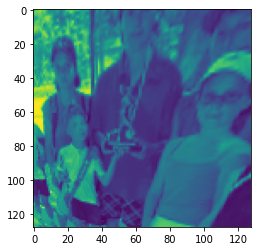

In [8]:
PB = tf.Session().run(warped_Pa[9])
plt.imshow(PB)

In [9]:
Ia_batches = tf.reshape(Ia_batches, [batch_size, h,w])
Pa = tf.gather_nd(Ia_batches, patch_indices, name=None, batch_dims=1)
Pa = tf.transpose(Pa, perm = [0,2,1])
Pa =  tf.Session().run(Pa)

Ia_batches_ =  tf.Session().run(Ia_batches).squeeze()

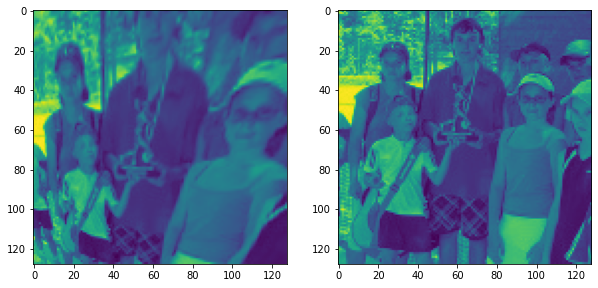

In [11]:
_,plts = plt.subplots(1,2,figsize=(10,5))
plts[0].imshow(X_train[9,:,:,1])
plts[1].imshow(Pa[9])

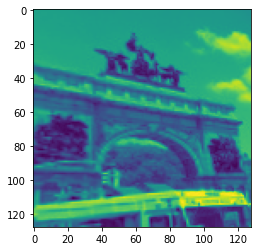

In [184]:
plt.imshow(X_train[0,:,:,1])

In [ ]:
######################### TF functions
def crop_tf(warped_Ia, corners_a):
    size = tf.constant([128,128], tf.int32)
    left_offsets = corners_a[:,:2]
    center_X = left_offsets[:,0]+64
    center_Y = left_offsets[:,1]+64
    centers =  tf.stack([center_Y,center_X],axis=1)
    warped_Pa = tf.image.extract_glimpse(warped_Ia,size,centers,centered=False,normalized=False)
    return warped_Pa


# to Print

(10, 240, 320, 1)


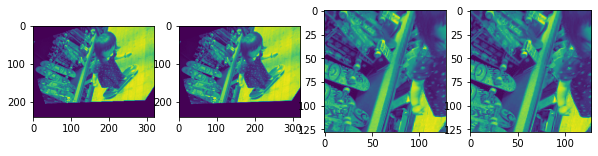

In [7]:
i = 2
print(tf.Session().run(warped_Ia).shape)
IA = tf.Session().run(Ia_batches[i]).squeeze()

warped_IA = tf.Session().run(warped_Ia[i]).squeeze()
warped_PA = tf.Session().run(warped_Pa[i]).squeeze()
IB = Ib_batches[i]

fig,plts = plt.subplots(1,4,figsize = (10,5))
plts[0].imshow(warped_IA)
plts[1].imshow(IB)
plts[2].imshow(warped_PA)
plts[3].imshow(PB[i])